# Double DQN - CartPole Experiment
* OpenAI gym 라이브러리의 CartPole 환경에서 논문의 <code>Figure 3</code>를 실습해봅시다.
* 논문 보는 곳(appendix version) : https://arxiv.org/abs/1509.06461
* 기본적인 CartPole 실습 코드 출처 : https://github.com/seungeunrho/RLfrombasics/blob/master/ch8_DQN.py
* CartPole rendering as gif 코드 출처 : https://gist.github.com/botforge/64cbb71780e6208172bbf03cd9293553

### 1. 사용할 라이브러리를 import (라이브러리 미설치 시 따로 설치해주세요)
* Episode gif rendering을 위해 <code>imagemagick</code> 설치가 요구됩니다 : https://imagemagick.org/script/download.php

In [1]:
import gym
import collections
import random
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from matplotlib import animation
from matplotlib import pyplot as plt
from IPython.display import set_matplotlib_formats # matplotlib 이미지 출력을 선명하게 하기 위해 필요합니다.
%matplotlib inline

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE" # 라이브러리들끼리 충돌을 일으켜서 matplotlib plot할 때 커널이 죽는 것을 방지

### 2. 하이퍼파라미터 및 환경 변수 세팅

In [2]:
learning_rate       =   0.0005   # Q network 학습에 사용 될 학습률 정의
batch_size          =   32       # Q network 학습 배치 사이즈
gamma               =   0.98     # 미래 보상 감쇠 인자
buffer_limit        =   50000    # experience replay buffer 크기
print_interval      =   500      # 몇 episode 당 학습 정보를 출력할 건지
freeze_interval     =   20       # Q target network 파라미터 업데이트 간격(단위 : episode)
trainable_buf_size  =   2000     # 학습이 시작되는 experience replay buffer 크기
repeat              =   15       # Figure를 뽑기 위해 총 몇 번의 학습을 수행할 지
training_step       =   1000000  # Figure의 x축 값(총 training step size)
inference_num       =   100      # 각 학습을 마친 뒤 actual q value를 구하기 위해 몇 episode를 돌릴 지
avg_step_size       =   10001    # 몇 training step size마다 q value를 평균낼 지

### 3. Experience Replay Class

In [3]:
class ReplayBuffer():
    def __init__(self):
        self.buffer = collections.deque(maxlen=buffer_limit)
    
    def put(self, transition):
        self.buffer.append(transition)
    
    def sample(self, n):
        mini_batch = random.sample(self.buffer, n)
        s_lst, a_lst, r_lst, s_prime_lst, done_mask_lst = [], [], [], [], []
        
        for transition in mini_batch:
            s, a, r, s_prime, done_mask = transition
            s_lst.append(s)
            a_lst.append([a])
            r_lst.append([r])
            s_prime_lst.append(s_prime)
            done_mask_lst.append([done_mask])

        return torch.tensor(s_lst, dtype=torch.float), torch.tensor(a_lst), \
               torch.tensor(r_lst), torch.tensor(s_prime_lst, dtype=torch.float), \
               torch.tensor(done_mask_lst)
    
    def size(self):
        return len(self.buffer)

### 4. Value Network Class (Q-network, Target Q-network)

In [4]:
class Qnet(nn.Module):
    def __init__(self):
        super(Qnet, self).__init__()
        self.fc1 = nn.Linear(4, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    # 학습 모드일 때는 epsilon greedy로 action을 뽑지만, 테스트 모드일 때는 greedy로 뽑는다.
    # max_a(Q(obs, a)) 값과, 선택한 action을 반환한다.
    def sample_action(self, obs, epsilon, mode):
        out = self.forward(obs)
        if mode == "train":
            coin = random.random()
            if coin < epsilon:
                return out.max(0)[0].item(), random.randint(0,1)
            else : 
                return out.max(0)[0].item(), out.argmax().item()
        elif mode == "test":
            return out.max(0)[0].item(), out.argmax().item()

### 5. Trainning function
* 한 번 호출될 때 버퍼에서 총 <code>10 * batch_size</code>개의 샘플을 뽑아 Q-network를 업데이트합니다.

In [5]:
def train(q, q_target, memory, optimizer, mode):
    for i in range(10):
        s,a,r,s_prime,done_mask = memory.sample(batch_size)

        # action a에 대한 현재 Q-network 값 가져오기
        q_out = q(s)
        q_a = q_out.gather(1,a)
        max_q_target_out = 0
        
        # dqn 학습일 경우 max_q_target_out = max_a(Q'(s', a))
        if mode == "dqn":
            max_q_target_out = q_target(s_prime).max(1)[0].unsqueeze(1)
        
        # double dqn 학습일 경우 max_q_target_out = max_a(Q'(s', argmax_a(Q(s', a))))
        elif mode == "double dqn":
            # argmax_a(Q(S', a)) 뽑기
            argmax_a = q(s_prime).max(1)[1].unsqueeze(1)

            # Q'(S', argmax_a)
            q_target_out = q_target(s_prime)
            max_q_target_out = q_target_out.gather(1, argmax_a)
            
            
        target = r + gamma * max_q_target_out * done_mask
        loss = F.smooth_l1_loss(q_a, target)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

### 6. Episode Rendering Download as gif
* CartPole episode를 원하는 경로에 gif 파일로 만들어주는 함수입니다.

In [6]:
def save_frames_as_gif(frames, n_epi):
    plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi=72)
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
    
    filename = f"\episode_{n_epi+1}.gif"
    anim.save(r'C:\Users\qhsl1\OneDrive\바탕 화면\trainning'+filename, writer='imagemagick', fps=24)
    plt.clf()

### 7. <code>Figure 3</code> graphing을 위한 전처리

In [7]:
def preprocess_for_Figure3(max_action_value_list):
    # avg_step_size 씩 training step을 묶어서 평균낸 값을 저장하기 위한 배열을 선언합니다.
    bundle_avg_max_action_value_list = [[0] for _ in range(repeat)]
    
    for i in range(repeat):
        # training_step % avg_step_size가 정확히 0이 아닐 수 있습니다.
        num_of_remained_steps = training_step % avg_step_size # 남는 부분의 크기를 구합니다.

        # avg_step_size씩 정확히 묶을 수 있는 부분
        avg_completed_list = max_action_value_list[i][:len(max_action_value_list[i])-num_of_remained_steps]

        # 남는 부분
        remained_list = max_action_value_list[i][len(avg_completed_list):]

        bundle_avg_max_action_value_list[i] = np.mean(avg_completed_list.reshape(-1, avg_step_size), axis=1)
        np.append(bundle_avg_max_action_value_list[i], np.array([np.mean(remained_list)]))

    
    bundle_avg_max_action_value_list = np.array(bundle_avg_max_action_value_list)
    
    # training step마다 median을 구합니다.
    median_list = np.median(bundle_avg_max_action_value_list, axis=0)

    # raining step마다 extreme values를 구합니다. 논문에선 10%, 90% 분위수를 뽑았지만, 여기선 그냥 max, min 값으로 plot 했습니다.
    max_value_list = bundle_avg_max_action_value_list.max(axis=0)
    min_value_list = bundle_avg_max_action_value_list.min(axis=0)
    
    return median_list, max_value_list, min_value_list

### 8. <code>Figure 3</code> graphing

In [8]:
def graph_Figure3(median_list, max_value_list, min_value_list, avg_actual_q_value, design):
    # matplotlib figure를 선명하게 출력하기 위한 작업입니다.
    # image format을 vector로 설정
    # set_matplotlib_formats('svg')

    # image size
    plt.rcParams['figure.dpi'] = 100
    plt.rcParams['savefig.dpi'] = 100
    x = np.arange(avg_step_size, training_step+1, avg_step_size)

    plt.plot(x, median_list, design, label='median', linewidth=2)
    plt.fill_between(x, max_value_list, min_value_list, color=design, alpha=0.3)

    plt.xlabel('Training steps', fontsize=12)
    plt.ylabel('Value estimates', fontsize=12)

    plt.axhline(y=avg_actual_q_value, color=design, linewidth=2)

    print(f"avg actual q-value : {avg_actual_q_value}")

    plt.show();

### 9. Main

<Training Mode : double dqn>

Current Repeat : 0
Episode :        500  |  avg epi score :      88.79  |  n_buffer :      44397  |  eps :       5.50%  |  training step :      44398
Episode :       1000  |  avg epi score :     260.47  |  n_buffer :      50000  |  eps :       3.00%  |  training step :     174635
Episode :       1500  |  avg epi score :     260.09  |  n_buffer :      50000  |  eps :       1.00%  |  training step :     304678
Episode :       2000  |  avg epi score :     224.92  |  n_buffer :      50000  |  eps :       1.00%  |  training step :     417136
Episode :       2500  |  avg epi score :     239.02  |  n_buffer :      50000  |  eps :       1.00%  |  training step :     536647
Episode :       3000  |  avg epi score :     284.25  |  n_buffer :      50000  |  eps :       1.00%  |  training step :     678772
Episode :       3500  |  avg epi score :     208.65  |  n_buffer :      50000  |  eps :       1.00%  |  training step :     783096
Episode :       4000  |  avg epi s

Episode :        500  |  avg epi score :      64.41  |  n_buffer :      32204  |  eps :       5.50%  |  training step :      32205
Episode :       1000  |  avg epi score :     208.78  |  n_buffer :      50000  |  eps :       3.00%  |  training step :     136595
Episode :       1500  |  avg epi score :     222.42  |  n_buffer :      50000  |  eps :       1.00%  |  training step :     247807
Episode :       2000  |  avg epi score :     200.30  |  n_buffer :      50000  |  eps :       1.00%  |  training step :     347958
Episode :       2500  |  avg epi score :     238.72  |  n_buffer :      50000  |  eps :       1.00%  |  training step :     467316
Episode :       3000  |  avg epi score :     262.99  |  n_buffer :      50000  |  eps :       1.00%  |  training step :     598811
Episode :       3500  |  avg epi score :     294.86  |  n_buffer :      50000  |  eps :       1.00%  |  training step :     746240
Episode :       4000  |  avg epi score :     389.08  |  n_buffer :      50000  |  e

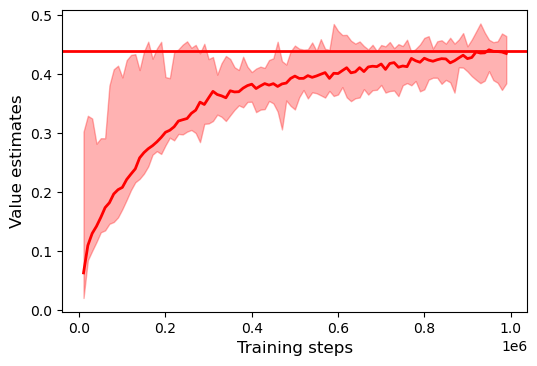

<Training Mode : dqn>

Current Repeat : 0
Episode :        500  |  avg epi score :      51.37  |  n_buffer :      25685  |  eps :       5.50%  |  training step :      25686
Episode :       1000  |  avg epi score :     178.16  |  n_buffer :      50000  |  eps :       3.00%  |  training step :     114764
Episode :       1500  |  avg epi score :     248.36  |  n_buffer :      50000  |  eps :       1.00%  |  training step :     238946
Episode :       2000  |  avg epi score :     273.83  |  n_buffer :      50000  |  eps :       1.00%  |  training step :     375861
Episode :       2500  |  avg epi score :     344.77  |  n_buffer :      50000  |  eps :       1.00%  |  training step :     548248
Episode :       3000  |  avg epi score :     240.80  |  n_buffer :      50000  |  eps :       1.00%  |  training step :     668647
Episode :       3500  |  avg epi score :     229.97  |  n_buffer :      50000  |  eps :       1.00%  |  training step :     783630
Episode :       4000  |  avg epi score : 

Episode :       2000  |  avg epi score :     287.58  |  n_buffer :      50000  |  eps :       1.00%  |  training step :     365448
Episode :       2500  |  avg epi score :     258.57  |  n_buffer :      50000  |  eps :       1.00%  |  training step :     494734
Episode :       3000  |  avg epi score :     292.76  |  n_buffer :      50000  |  eps :       1.00%  |  training step :     641113
Episode :       3500  |  avg epi score :     249.37  |  n_buffer :      50000  |  eps :       1.00%  |  training step :     765800
Episode :       4000  |  avg epi score :     331.19  |  n_buffer :      50000  |  eps :       1.00%  |  training step :     931397

Current Repeat : 9
Episode :        500  |  avg epi score :     126.10  |  n_buffer :      50000  |  eps :       5.50%  |  training step :      63049
Episode :       1000  |  avg epi score :     304.55  |  n_buffer :      50000  |  eps :       3.00%  |  training step :     215323
Episode :       1500  |  avg epi score :     230.32  |  n_buffe

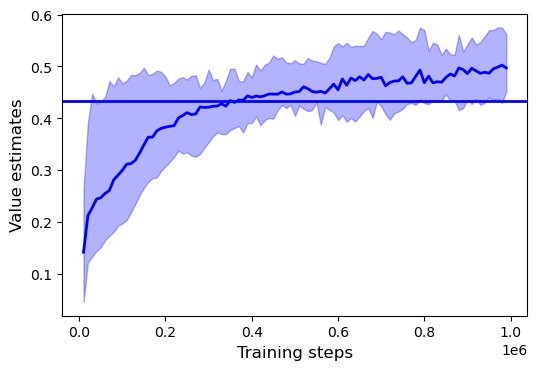

In [9]:
def main(mode):
    
    print(f"<Training Mode : {mode}>")
    
    # 각 학습에서, 각 training step마다 해당 step에서의 max_a(Q(s, a)) 값을 저장하기 위한 2차원 배열입니다.
    max_action_value_list = [[0] for _ in range(repeat)]

    # 학습이 끝난 후 각 inference 마다의 return과 step size를 더해줍니다. figure 3에서 y = averaged_return / total_step 직선이 그래핑 됩니다.
    total_return = 0
    total_step = 0
    
    
    # repeat번의 학습을 수행합니다.
    for i in range(repeat):
        print(f"\nCurrent Repeat : {i}")
        
        # Neural Network and Replay buffer initialization
        q = Qnet()
        q_target = Qnet()
        q_target.load_state_dict(q.state_dict())
        memory = ReplayBuffer()
        optimizer = optim.Adam(q.parameters(), lr=learning_rate)
        
        # CartPole Environment initialization
        env = gym.make('CartPole-v1')
        total_epi_score = 0.0
        n_epi = 0
        
        while len(max_action_value_list[i]) < training_step:
            epsilon = max(0.01, 0.08 - 0.01*(n_epi/200))
            epi_score = 0.0
            frames = [] # Episode frame을 담을 리스트
            s = env.reset()
            done = False
          
            # print_interval마다 에피소드를 gif로 저장합니다.
            rendering = False # True if (n_epi+1)%print_interval==0 else False

            while not done:
                if rendering == True:
                    frames.append(env.render(mode="rgb_array"))
          
                max_a, a = q.sample_action(torch.from_numpy(s).float(), epsilon, "train")
                
                # 각 step마다의 max_a(Q(s, a))를 뽑아서 배열에 저장합니다.
                max_action_value_list[i] += [max_a]
                
                s_prime, r, done, info = env.step(a)
                done_mask = 0.0 if done else 1.0
                memory.put((s,a,r/100.0,s_prime, done_mask))
                s = s_prime
                epi_score += r
                
            n_epi += 1
            total_epi_score += epi_score
          
          
            # 에피소드를 gif로 렌더링
            if rendering == True:
                save_frames_as_gif(frames, n_epi)
          
            
            # 학습
            if memory.size() > trainable_buf_size:
                train(q, q_target, memory, optimizer, mode)
            
            
            # 학습 상태 출력
            if n_epi % print_interval == 0 and n_epi != 0:
                print(f"Episode : {n_epi : 10d}  |  avg epi score : {total_epi_score/print_interval : 10.2f}  |  n_buffer : {memory.size() : 10d}  |  eps : {epsilon*100 : 10.2f}%  |  training step : {len(max_action_value_list[i]) : 10d}")
                
                total_epi_score = 0

                
            # Target Q-network 파라미터 업데이트
            if (n_epi+1) % freeze_interval == 0 and n_epi != 0:
                q_target.load_state_dict(q.state_dict())

        
        env.close()
        max_action_value_list[i] = max_action_value_list[i][:training_step]
        
        
        # 학습 완료 후 inference_num번의 inference를 통해 actural return 구하기.
        for inference in range(inference_num):
            env = gym.make('CartPole-v1')
            s = env.reset()
            done = False
            history = [] # step마다의 보상을 기록합니다.
            
            while not done:
                max_a, a = q.sample_action(torch.from_numpy(s).float(), epsilon, "test") # greedy로 action을 뽑습니다.
                s_prime, r, done, info = env.step(a)
                done_mask = 0.0 if done else 1.0
                s = s_prime
                history.append(r/100)
                total_step += 1

            cum_reward = 0
            for reward in history[::-1]:
                cum_reward = reward + gamma*cum_reward
                total_return += cum_reward # Episode에서 방문했던 각 state에서의 return을 더해줍니다.

            env.close()
    
    
    max_action_value_list = np.array(max_action_value_list)
    median_list, max_value_list, min_value_list = preprocess_for_Figure3(max_action_value_list)
    
    design = "blue" if mode == "dqn" else "red"
    graph_Figure3(median_list, max_value_list, min_value_list, total_return/total_step, design)

    


if __name__ == '__main__':
    main("double dqn") # double dqn으로 CartPole 학습
    main("dqn") # dqn으로 CartPole 학습